In [1]:
# Standard imports:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Constants:

# Contains 1.6M samples
PATH_DATA = "../input/sentiment140/training.1600000.processed.noemoticon.csv"

# GloVe Twitter embeddings: 2B tweets, 27B tokens, 1.2M vocab, uncased,200-dimensional
PATH_EMB = "../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt"
N_EMB = 200 # Dimensions of the embeddings

# Using fastText Word vectors trained on Wikipedia 2017, UMBC webbase corpus, and statmt.org
# PATH_EMB = "../input/fasttext-wikinews/wiki-news-300d-1M.vec"
# N_EMB = 300

# Number of samples to be taken
LIMIT = 10000 #1600000

# Fraction of samples to be used for training set
N_TRAIN = 0.9

# Size of each sequence to be embedded:
N_SEQ = 0 # Chosen later based on the histogram of the lengths

## Data reading and pre-processing

In [4]:
# Function that returns the processed dataframe
def loadDF(n_samples):
    
    # Read
    df = pd.read_csv(
        PATH_DATA, 
        encoding = "latin", # No encoding results in decode error 
        header = None
    )
    
    # Drop columns which aren't needed
    df.drop(labels = [1,2,3,4], axis = "columns", inplace = True)
    df.columns = ["Label", "Text"]
    
    # Relabel 0 -> 0 and 4 -> 1 (0:Negative, 1:Positive)
    df.replace(to_replace = 4, value = 1, inplace = True)
    
    # Training on 1.6M samples takes a lot of time, we train on a smaller randomized subset of the data
    df = df.sample(n = n_samples, random_state = 42)
    
    return df

In [5]:
df = loadDF(LIMIT)
print("Class distribution:\n{}".format(df["Label"].value_counts()))

Class distribution:
0    5004
1    4996
Name: Label, dtype: int64


## Cleaning the data:

In [6]:
# Check for null values
check = df.isnull().sum()
print(check)

Label    0
Text     0
dtype: int64


## WordCloud visualization:

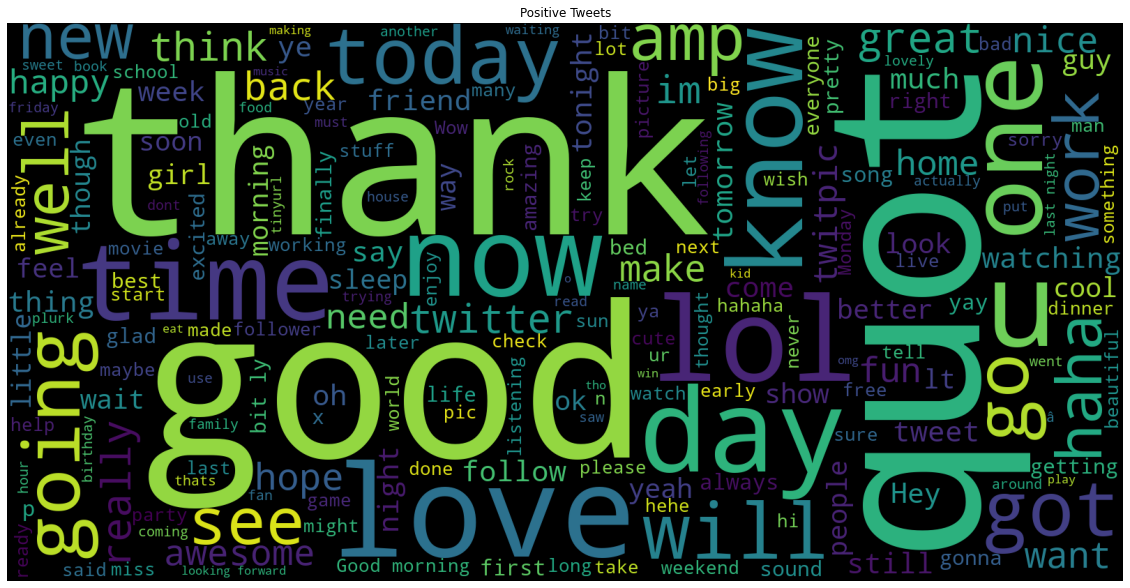

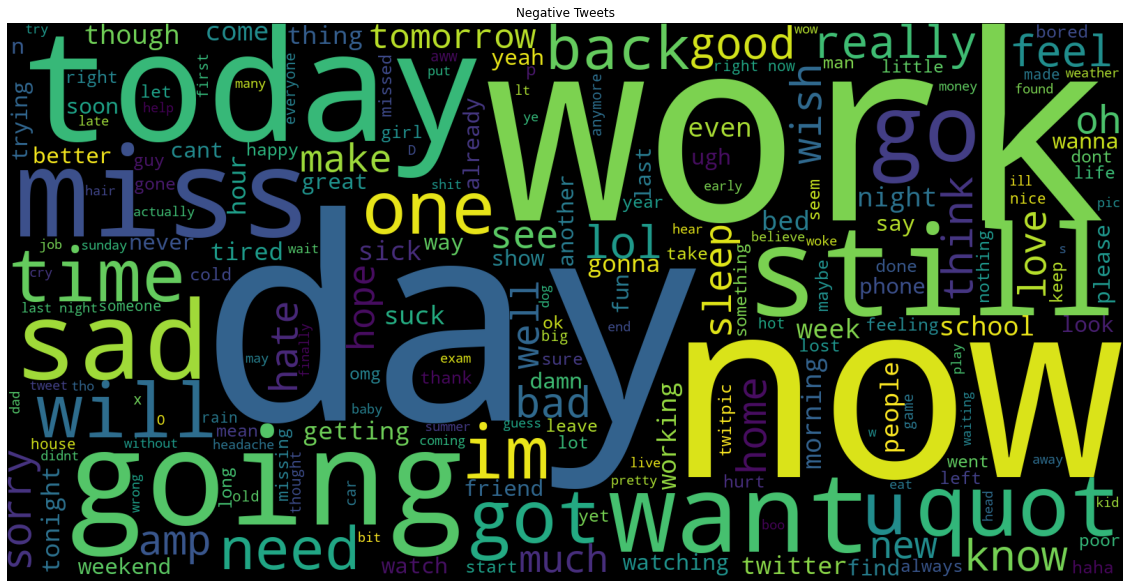

In [7]:
from wordcloud import WordCloud

df_pos = df.loc[df["Label"] == 1]
df_neg = df.loc[df["Label"] == 0]

wc_pos = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_pos["Text"])) 

wc_neg = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_neg["Text"])) 

plt.figure(figsize = (20,20))
plt.imshow(wc_pos)
plt.title("Positive Tweets")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neg)
plt.title("Negative Tweets")
plt.axis("off")
plt.show()

In [8]:
# Add common words as stopwords
n_sw = 50 # Add n_sw of the top common words as stop words
top_pos = list(wc_pos.words_.keys()) # Sorted in decr order of frequencies, len=200
top_neg = list(wc_neg.words_.keys())
common = list(set(top_pos[:n_sw]) & set(top_neg[:n_sw]))
print(common)

['make', 'day', 'really', 'now', 'quot', 'know', 'u', 'going', 'well', 'im', 'time', 'work', 'new', 'still', 'go', 'come', 'love', 'one', 'today', 'will', 'think', 'got', 'oh', 'need', 'home', 'amp', 'back', 'good', 'see', 'tomorrow', 'lol', 'hope', 'night', 'want']


In [9]:
# Only select some, as others are meaningful
common = ["amp", "quot", "lol" "u"]

In [10]:
import re
import nltk
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer

puncs = string.punctuation
sw = stopwords.words("english") # Not used as it contains "don't" "not" "did't" which are "negative" and will change the meaning of the sentence
sb = SnowballStemmer(language = "english") # Better and faster than PorterStemmer
# https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions (@username), all URLs, all hashtags.  (\S+ matches with everything that is not a whitespace)
    text = re.sub("@\S+|http\S+|#\S+", "", text)
    # Remove punctuations (Redundant step, handled later in Keras tokenizer)
    text.translate(str.maketrans('', '', puncs))
    # Strip off accents (convert to ascii)
    text = unidecode(text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    # Don't stem as overlap with embeddings vocab is close to 0 
    # DON'T remove stop words as they carry imp info about the meaning of the sentence and non-alphanumeric tokens
    cleaned_tokens = [t for t in tokenized_text if t.isalnum() and t not in common]
    cleaned_string = " ".join(cleaned_tokens)
    return cleaned_string

In [11]:
from tqdm import tqdm
tqdm.pandas()

def cleanDF(df):
    df["Text"] = df["Text"].progress_apply(lambda x : preprocess(x))
    return df

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [12]:
# This takes a lot of time
df = cleanDF(df)
display(df)

100%|██████████| 10000/10000 [00:03<00:00, 3027.38it/s]


,Label,Text
541200,0,ahhh i hope your ok
750,0,cool i have no tweet apps for my razr 2
766711,0,i know just family drama its next time u hang ...
285055,0,school email wo open and i have geography stuf...
705995,0,upper airways problem
...,...,...
965972,1,my sister cheyenne birthday party is today it ...
1193436,1,you are so welcome
896390,1,seriously those gals were making me nervous pa...
544127,0,thanks now i want chicken and cheesecake not t...


## Analyze the length of the tweets:
This will help us select the `N_SEQ`

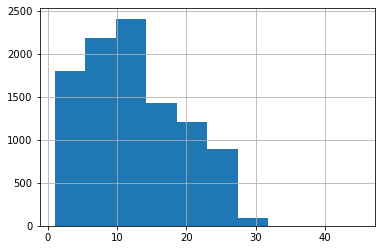

Mean: 12.4030
Std: 6.8302
Mean+3*Std = 32.8935


In [13]:
lengths = df["Text"].apply(lambda x : len(x.split(" "))) # try mean + 3*sigma
lengths.hist()
plt.show()

mean = lengths.mean()
std = lengths.std()
approx_nseq = mean + 3*std
print(f"Mean: {mean:.4f}\nStd: {std:.4f}\nMean+3*Std = {approx_nseq:.4f}")

Thus we keep `N_SEQ = 32` (Power of 2)

In [14]:
N_SEQ = 32

## Preparation before model training
Doing this in Keras is quite simple and intuitive

In [15]:
from sklearn.model_selection import train_test_split as tts

# Split into training and validation sets
df_train, df_val = tts(df, train_size = N_TRAIN, shuffle = True, random_state = 42)

Below stuff can be done using `numpy` as well, but Keras is being used just for simplicity

In [16]:
from keras.preprocessing.text import Tokenizer

def getTokenizer():
    tok = Tokenizer()
    # Create word_index and vocab
    tok.fit_on_texts(df_train["Text"])
    return tok

In [17]:
tok = getTokenizer()
word_index = tok.word_index
N_vocab = len(tok.word_index) + 1 # +1 for the 0 padding
print(N_vocab)

12385


In [18]:
from keras.preprocessing.sequence import pad_sequences

def getXY(tok):
    x_train = pad_sequences(tok.texts_to_sequences(df_train["Text"]), maxlen = N_SEQ, padding = "post")
    x_val   = pad_sequences(tok.texts_to_sequences(df_val["Text"]), maxlen = N_SEQ, padding = "post")
    y_train = df_train["Label"].to_numpy(dtype = float).reshape(-1, 1)
    y_val   = df_val["Label"].to_numpy(dtype = float).reshape(-1, 1)
    return x_train, x_val, y_train, y_val

In [19]:
x_train, x_val, y_train, y_val = getXY(tok) # All are nice numpy arrays

In [20]:
N_BATCH = 128

## Preparing the Embeddings

In [214]:
import torch

In [215]:
# Maps each word in the embeddings vocabulary to it's embedded representation 
embeddings_index = {}
with open(PATH_EMB, "r", errors="ignore") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

1193514it [02:05, 9526.37it/s]


In [216]:
# Maps each word in our vocab to it's embedded representation, if the word is present in the GloVe embeddings
embedding_matrix = np.zeros((N_vocab, N_EMB))
n_match = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        n_match += 1
        embedding_matrix[i] = embedding_vector
print("Vocabulary match: ", n_match)

# Convert to torch tensor to be used directly in the embedding layer:
embeddings_tensor = torch.FloatTensor(embedding_matrix)

Vocabulary match:  10889


In [217]:
from torch.utils.data import DataLoader, TensorDataset

# Data ready to be loaded:
data_train = TensorDataset(torch.from_numpy(x_train).long(), torch.from_numpy(y_train).long())
data_val = TensorDataset(torch.from_numpy(x_val).long(), torch.from_numpy(y_val).long())

In [218]:
# Create dataloaders
loader_train = DataLoader(data_train, shuffle = True, batch_size = N_BATCH)
loader_val = DataLoader(data_val, shuffle = True, batch_size = N_BATCH)

This means only some match with the Twitter GloVe embeddings (We can improve this)

## The Model:
Based on [this](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb) tutorial

In [246]:
N_EPOCHS = 5
OUTPUT_DIM = 1
HIDDEN_DIM = 64

In [247]:
def countParameters(model):
    """ Counts the total number of trainiable parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

In [248]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # Round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [249]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [250]:
import torch.nn as nn

class LSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout = 0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor, freeze = True)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers = 2, 
            bidirectional = True, 
            dropout = dropout,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_dim*2, output_dim) # As bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        # text: [sentlen, batch size]
        
        embedded = self.embedding(text)  # [batch size, sent len, emb dim]
        
        # lstm_output: concatentation of all hidden states
        # hidden: The final hidden state h_T
        
        lstm_output, (hidden, cell) = self.lstm(embedded) # [batch size, sent len, hid dim], [ batch size, 1, hid dim] 
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        
        output = self.fc(hidden)
        
        return output # No need for sigmoid, our loss function will apply that for us

In [251]:
model = LSTM(N_vocab, N_EMB, HIDDEN_DIM, OUTPUT_DIM)
trainable, frozen = countParameters(model)

print(model)
print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

LSTM(
  (embedding): Embedding(12385, 200)
  (lstm): LSTM(200, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
The model has 235,649 trainable parameters and 2,477,000 frozen parameters


In [252]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss() # This computes sigma(logits) too

# Place on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [253]:
def train(model, iterator, optimizer, criterion):
    """ Trains the model on the given training set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # Tells your model that you are training the model
    
    for text, label in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(text)
        
        label = label.type_as(predictions)
        
        loss = criterion(predictions, label)
        
        acc = binary_accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [254]:
def evaluate(model, iterator, criterion):
    """ Evaluates the model on the validation set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # Tells the model that we are currently evaluating the model
    
    with torch.no_grad(): # Temporarily set all the requires_grad flag to false
    
        for text, label in iterator:

            predictions = model(text)
            
            label = label.type_as(predictions)
            
            loss = criterion(predictions, label)
            
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [255]:
# The actual training and validation:

best_valid_loss = float("inf")

history = {
    "t_loss" : [],
    "v_loss" : [],
    "t_acc" : [],
    "v_acc" : []
}

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, loader_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, loader_val, criterion)
    
    end_time = time.time()
    
    history["t_loss"].append(train_loss)
    history["v_loss"].append(valid_loss)
    history["t_acc"].append(train_acc)
    history["v_acc"].append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Saves best only
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    # Print details about each epoch:
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.622 | Train Acc: 64.70%
	 Val. Loss: 0.580 |  Val. Acc: 68.95%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.524 | Train Acc: 74.54%
	 Val. Loss: 0.541 |  Val. Acc: 70.38%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.478 | Train Acc: 77.33%
	 Val. Loss: 0.522 |  Val. Acc: 73.92%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.465 | Train Acc: 78.12%
	 Val. Loss: 0.516 |  Val. Acc: 74.77%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.438 | Train Acc: 79.06%
	 Val. Loss: 0.518 |  Val. Acc: 73.24%


In [ ]:
t_acc = history["t_acc"]
t_loss = history["t_loss"]
v_acc = history["v_acc"]
v_loss = history["v_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")

plt.show()